In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import os.path
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.listdir('/content/drive/MyDrive')

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

In [ ]:
for line in open('/content/drive//MyDrive/SMSSpamCollection'):
  if line[0:3]=='ham':
    print(line)
    break
for line in open('/content/drive//MyDrive/SMSSpamCollection'):
  if line[0:4]=='spam':
    print(line)
    break

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



The label of a spam image is 'spam'. The label of a non-spam image is 'ham'. Later, spams will be labeled as 1 and non-spams will be 0.

In [ ]:
cnt=0
spcnt=0
hcnt=0
f=open('/content/drive//MyDrive/SMSSpamCollection','r')
sc=f.readlines()
print(len(sc))
for line in sc:
    cnt+=1
    if line[0:3]=='ham':
      hcnt+=1
    elif line[0:4]=='spam':
      spcnt+=1
print(cnt)
print(hcnt)
spcnt

5574
5574
4827


747

There are 4827 non-spam messages and 747 spam messages.

In [ ]:
import torchtext
from torchtext.legacy import data
text_field = data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = data.TabularDataset("/content/drive//MyDrive/SMSSpamCollection", # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)

# dataset[0].sms
# dataset[0].label
# train, valid, test = ...

In [ ]:
dataset[5081].sms

'Keep ur problems in ur heart, b\'coz nobody will fight for u. Only u &amp; u have to fight for ur self &amp; win the battle. -VIVEKANAND- G 9t.. SD..\nham\tYeah, give me a call if you\'ve got a minute\nham\tHI BABE UAWAKE?FEELLIKW SHIT.JUSTFOUND OUT VIA ALETTER THATMUM GOTMARRIED 4thNOV.BEHIND OURBACKS \x96 FUCKINNICE!SELFISH,DEVIOUSBITCH.ANYWAY,I\x92L CALL U"'

In [ ]:
train,val,test=dataset.split(split_ratio=[0.6,0.2,0.2])
len(test)

1114

We will duplicate spam messages in the training set,
so that the training set is roughly balanced.

In [ ]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

If differently labeled samples are not balanced in number, the model will get trained more on one label and less on another. The result is the model will bias to the label it had seen more. In this case, if we do not duplicate spam messages, it will tend to predict spams as non-spams.

text_field.vocab.stoi represents the numerical integer identifier of each token. text_field.vocab.itos gives the list of tokens ranked by numerical identifier.

In [ ]:
text_field.build_vocab(train)
#text_field.vocab.stoi
#text_field.vocab.itos

In [ ]:
text_field.vocab.itos

['<unk>',
 '<pad>',
 ' ',
 'e',
 'o',
 't',
 'a',
 'n',
 'r',
 'i',
 's',
 'l',
 'u',
 'h',
 '0',
 'd',
 '.',
 'm',
 'c',
 'y',
 'w',
 'p',
 'g',
 'f',
 '1',
 'b',
 '2',
 'T',
 '8',
 'k',
 'E',
 'v',
 '5',
 'S',
 'C',
 'O',
 'I',
 '7',
 'N',
 '4',
 'x',
 'A',
 'R',
 '3',
 ',',
 '6',
 '!',
 'P',
 'M',
 '9',
 'L',
 'U',
 'W',
 'H',
 'D',
 'F',
 'B',
 '/',
 'G',
 'Y',
 "'",
 '?',
 '£',
 '-',
 '&',
 ':',
 'X',
 'z',
 'V',
 'j',
 'K',
 '*',
 'J',
 '+',
 ';',
 ')',
 'Q',
 'q',
 '"',
 '(',
 '#',
 '>',
 '=',
 '@',
 'ü',
 'Z',
 'Ü',
 '$',
 '<',
 '_',
 '|',
 '\x92',
 '[',
 ']',
 '%',
 '‘',
 '’',
 '\x93',
 'ú',
 '…',
 '~',
 '\x94',
 '–',
 '\\',
 '^',
 'è',
 'ì',
 '—',
 '┾',
 '〨',
 '鈥']

In [ ]:
stois=list(text_field.vocab.stoi.keys())
itoss=text_field.vocab.itos
for i in range(len(stois)):
  if not stois[i] in itoss:
    print(i,' ',stois[i])

`<unk>` is used for representing the unknown tokens. `<pad>` represents the special tokens and paddings attached to shorter samples to make every sample the same length.

In [ ]:
train_iter = data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
val_iter = data.BucketIterator(val,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
test_iter = data.BucketIterator(test,
                                           batch_size=len(test),
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
bcnt=0
inlens=[]
numpads=[]
for batch in train_iter:
    #print('bcnt:',bcnt)
    #print('batch:',batch)
    if 1:#bcnt==0:
      scnt=0
      for sample in batch:
        #print('sample',scnt,':',(sample))
        if scnt==0:
          inlens.append(sample[0].shape[1])
          num_non0=torch.count_nonzero(sample[0]-1)
          mynumpad=sample[0].shape[0]*sample[0].shape[1]-num_non0
          #print('num nonzeros:',num_non0)
          #print('num zeros:',mynumpad)
          numpads.append(int(mynumpad.detach().numpy()))
        scnt+=1
    #print('len(batch):',len(batch))
    #print('batch.sms：',batch.sms)
    #print('batch.label:',batch.label)
    bcnt+=1
    if bcnt==10:
      break
print('inlens:',inlens)
print('numpads:',numpads)

inlens: [156, 157, 133, 160, 53, 162, 35, 158, 154, 156]
numpads: [0, 0, 25, 0, 43, 8, 9, 0, 31, 11]


The maximum length of the input sequence in each of the 10 batchs is [50, 158, 71, 22, 151, 89, 139, 24, 24, 45]. The number of `<pad>` used in each of the 10 batchs is [20, 25, 13, 0, 4, 31, 18, 0, 32, 13]. As each batch differ greatly in maximum sample length, putting similar length samples in one batch have saved a lot of paddings.

##Model Building

In [ ]:
ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [ ]:
maxs=[]
rsizes=[]
def idxiter21hot(train_iter,identmax=len(text_field.vocab.itos)):
  global maxs
  maxs=[]
  train_1h=[]
  ident = torch.eye(identmax)
  for batch in train_iter:
    sample_1h=[]
    scnt=0
    for sample in batch:
      if scnt==0:
        maxs.append(torch.max(sample[0]))
        sample_1h.append(ident[sample[0]])
      elif scnt==1:
        sample_1h.append(sample)
      scnt+=1
    train_1h.append(sample_1h)
  #print (max(maxs))
  return train_1h

In [ ]:
train_1h=idxiter21hot(train_iter)
val_1h=idxiter21hot(val_iter)
test_1h=idxiter21hot(test_iter)
print('lengths:',len(train_iter),len(val_iter),len(test_iter))


lengths: 190 35 1


In [ ]:
class RNN(nn.Module):
  def __init__(self,input_size, hidden_size, num_classes,rout='max',activation='tanh'):
    super(RNN,self).__init__()
    self.rout=rout
    self.activation=activation
    self.hidden_size = hidden_size
    self.rnn=nn.RNN(input_size,hidden_size,batch_first=True,nonlinearity=activation)
    fcsizein=hidden_size
    if rout=='cat':
      fcsizein=hidden_size*2
    self.fc=nn.Linear(fcsizein,num_classes)
        
  def forward(self,x):
    global rsizes
    rsizes=[]
    rsizes.append(x.shape)
    h0 = torch.zeros(1, x.size(0), self.hidden_size)
    rnd,_=self.rnn(x,h0)
    rsizes.append(rnd.shape)
    fcd=None;
    if self.rout=='last':
      fcd=self.fc(rnd[:, -1, :])
    if self.rout=='max':
      fcd=self.fc(torch.max(rnd, dim=1)[0])
    elif self.rout=='cat':
      fcd=self.fc(torch.cat([torch.max(rnd, dim=1)[0], 
                              torch.mean(rnd, dim=1)], dim=1))
    #print (torch.max(rnd, dim=1)[0].shape)
    rsizes.append(fcd.shape)
    return fcd


In [ ]:
rnn0=RNN(114,114,2)
rnn0(torch.rand([3,54,114]))
#torch.rand([2,1,1,1]).squeeze()

tensor([[ 0.0743, -0.5968],
        [ 0.0960, -0.5886],
        [ 0.1116, -0.6334]], grad_fn=<AddmmBackward0>)

Training

In [ ]:
def get_accuracy(model, data_loader):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    correct, total = 0, 0
    tp,tn=0,0
    for tweets, labels in data_loader:
        output = model(tweets)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
        mytp=torch.count_nonzero(labels)
        tp+=mytp
        tn+=len(labels)-mytp
    print('num of 1 and 0 in labels:',tp,tn)
    #print('correct:',correct)
    #print('total:',total)
    return correct / total

In [ ]:
import matplotlib.pyplot as plt
def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs):
        for tweets, labels in train:
            optimizer.zero_grad()
            pred = model(tweets)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train))
        valid_acc.append(get_accuracy(model, valid))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
        #print('epoch:',epoch)
        #print('loss:',loss,'train_acc:',train_acc[-1],'valid_acc:',valid_acc[-1])
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

num of 1 and 0 in labels: tensor(3178) tensor(2889)
num of 1 and 0 in labels: tensor(135) tensor(980)
Epoch 1; Loss 0.679849; Train Acc 0.479644; Val Acc 0.878027
num of 1 and 0 in labels: tensor(3178) tensor(2889)
num of 1 and 0 in labels: tensor(135) tensor(980)
Epoch 2; Loss 0.685760; Train Acc 0.866656; Val Acc 0.766816
num of 1 and 0 in labels: tensor(3178) tensor(2889)
num of 1 and 0 in labels: tensor(135) tensor(980)
Epoch 3; Loss 0.688447; Train Acc 0.611999; Val Acc 0.269955
num of 1 and 0 in labels: tensor(3178) tensor(2889)
num of 1 and 0 in labels: tensor(135) tensor(980)
Epoch 4; Loss 0.687759; Train Acc 0.561563; Val Acc 0.181166
num of 1 and 0 in labels: tensor(3178) tensor(2889)
num of 1 and 0 in labels: tensor(135) tensor(980)
Epoch 5; Loss 0.683843; Train Acc 0.566837; Val Acc 0.191031
num of 1 and 0 in labels: tensor(3178) tensor(2889)
num of 1 and 0 in labels: tensor(135) tensor(980)
Epoch 6; Loss 0.675407; Train Acc 0.634581; Val Acc 0.314798
num of 1 and 0 in labe

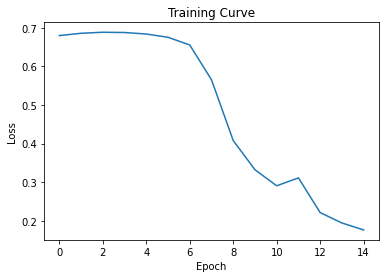

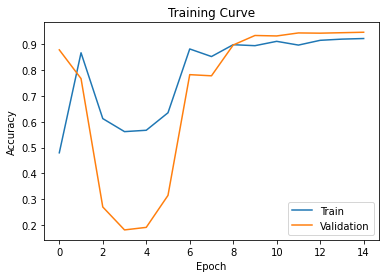

In [ ]:
rnn1=RNN(len(text_field.vocab.itos),len(text_field.vocab.itos),2,rout='cat',activation='tanh')
train_rnn_network(rnn1, train_1h, val_1h, num_epochs=15, learning_rate=2e-5)

num of 1 and 0 in labels: tensor(3178) tensor(2889)
num of 1 and 0 in labels: tensor(135) tensor(980)
Epoch 1; Loss 0.162140; Train Acc 0.939344; Val Acc 0.951570
num of 1 and 0 in labels: tensor(3178) tensor(2889)
num of 1 and 0 in labels: tensor(135) tensor(980)
Epoch 2; Loss 0.140238; Train Acc 0.939838; Val Acc 0.951570
num of 1 and 0 in labels: tensor(3178) tensor(2889)
num of 1 and 0 in labels: tensor(135) tensor(980)
Epoch 3; Loss 0.127471; Train Acc 0.943794; Val Acc 0.949776


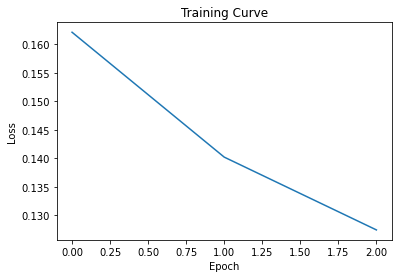

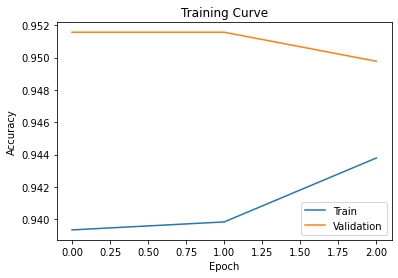

In [ ]:
train_rnn_network(rnn1, train_1h, val_1h, num_epochs=3, learning_rate=2e-5)

In [ ]:
# Create a Dataset of only spam validation examples
valid_spam = data.Dataset(
    [e for e in val.examples if e.label == 1],
    val.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = data.Dataset(
    [e for e in val.examples if e.label == 0],
    val.fields) 

In [ ]:
val_spam_iter = data.BucketIterator(valid_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
val_nospam_iter = data.BucketIterator(valid_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

val_spam1h=idxiter21hot(val_spam_iter)
val_nospam1h=idxiter21hot(val_nospam_iter)

In [ ]:
fpr=1-get_accuracy(rnn1, val_nospam1h)
fnr=1-get_accuracy(rnn1, val_spam1h)
print('false positive rate:',fpr)
print('false negative rate:',fnr)

num of 1 and 0 in labels: tensor(0) tensor(980)
num of 1 and 0 in labels: tensor(135) tensor(0)
false positive rate: 0.055102040816326525
false negative rate: 0.0444444444444444


The impact of a false positive is classifying a useful message as a spam. This will possibly make important messages ignored by the user. The impact of a false negative is classifying a spam as something useful. This will be annoying, and could possibly lead to economic losses of the user if the spam message is a fraud.

In [ ]:
test_iter = data.BucketIterator(test,
                                batch_size=32,
                                sort_key=lambda x: len(x.sms), # to minimize padding
                                sort_within_batch=True,        # sort within each batch
                                repeat=False)
test_1h=idxiter21hot(test_iter)
test_acc=get_accuracy(rnn1, test_1h)
print('test accuracy:',test_acc)

num of 1 and 0 in labels: tensor(158) tensor(956)
test accuracy: 0.9488330341113106


The final test accuracy is 0.949.

Evaluating false positive rate and false negative rate of the model across the test set

In [ ]:
test_spam = data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)
test_nospam = data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)
test_spam_iter = data.BucketIterator(test_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
test_nospam_iter = data.BucketIterator(test_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

test_spam1h=idxiter21hot(test_spam_iter)
test_nospam1h=idxiter21hot(test_nospam_iter)
fpr_test=1-get_accuracy(rnn1, test_nospam1h)
fnr_test=1-get_accuracy(rnn1, test_spam1h)
print('false positive rate:',fpr_test)
print('false negative rate:',fnr_test)

num of 1 and 0 in labels: tensor(0) tensor(956)
num of 1 and 0 in labels: tensor(158) tensor(0)
false positive rate: 0.05125523012552302
false negative rate: 0.06329113924050633


Evaluate the model's prediction of the probability that
the SMS message "machine learning is sooo cool!" is spam

In [ ]:
msg = "machine learning is sooo cool!"

In [ ]:
charints=[]
for c in msg:
  charints.append(text_field.vocab.stoi[c])
ident = torch.eye(len(text_field.vocab.itos))
char1hots=ident[torch.tensor(charints)].unsqueeze(0)
msgset=[[char1hots,torch.tensor([1])],]
msgset[0]
pred=rnn1(char1hots)
print(pred)

tensor([[ 0.7992, -0.5443]], grad_fn=<AddmmBackward0>)


In [ ]:
#get_accuracy(rnn1, msgset)
pred=pred[0].squeeze()
probspam=((pred[1]+1)/(pred[1]+pred[0]+2)) #add 1 to each output to correct for the tanh function, otherwise will get negative probability
probspam

0.20209321921149495

The probability for this message to be spam is 0.2021, which is fairly low.